**Prerequisite:** Before running this notebook for the first time, ``data_extraction_&_data_wrangling.ipynb`` should be executed once to generate cleaned dataset in the project folder.

This notebook includes the following processes:

[A. Exploratory Data Analysis](#A.-Exploratory-Data-Analysis)  
[B. Feature Scaling](#B.-Feature-Scaling)  
[C. Building Regression Model (Baseline Model)](#C.-Building-Regression-Model-(Baseline-Model))  
[D. Model Evaluation](#D.-Model-Evaluation)  
[E. Model Diagnostics (Residual Analysis)](#E.-Model-Diagnostics-(Residual-Analysis))  
[F. Model Refinement](#F.-Model-Refinement)  
[G. Conclusion](#G.-Conclusion)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## A. Exploratory Data Analysis

In [2]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_data.csv')
df.head()

,county,poverty_rate,health_insurance,median_household_income,unemployment_rate,public_transit,median_house_value,median_gross_rent,bachelor_holders,public_assistance
0,"Baldwin County, Alabama",9.7,93.2,72915,2.0,0.0,307000,1286,20.64,0.58
1,"Calhoun County, Alabama",21.3,91.1,50780,5.4,0.0,160900,782,11.84,1.65
2,"Cullman County, Alabama",18.3,89.4,58923,3.8,0.3,204000,788,10.75,1.34
3,"DeKalb County, Alabama",24.7,86.1,43509,3.8,0.0,156800,659,9.33,2.66
4,"Elmore County, Alabama",12.9,92.4,72478,2.7,0.0,229900,933,17.73,0.17


### 1. Sample size

In [3]:
# Show the number of rows (counties)
df.shape[0]

854

In [4]:
# Retrieve state names
states = df['county'].apply(lambda x: x.split(','))
# Show the number of states included in the data
states.apply(lambda x: x[1]).nunique()

52

In [5]:
# Show how many counties in each state are included in the dataset
states.apply(lambda x: x[1]).value_counts()

county
Texas                   56
North Carolina          44
California              42
Florida                 41
Pennsylvania            40
Georgia                 39
New York                38
Ohio                    38
Virginia                30
Michigan                30
Indiana                 27
Wisconsin               25
Illinois                22
South Carolina          22
New Jersey              21
Tennessee               21
Washington              20
Alabama                 20
Louisiana               17
Missouri                17
Maryland                16
Minnesota               16
Oregon                  15
Kentucky                14
Massachusetts           12
Colorado                12
Mississippi             11
Oklahoma                11
Arkansas                11
Puerto Rico             11
Arizona                 10
Iowa                    10
New Mexico               9
Connecticut              9
Kansas                   8
New Hampshire            7
West Virginia        

**Key findings:**
- There are 854 counties. This is a good sample size for multiple linear regression.
- The number of states is 52. This is because District of Columbia and Puerto Rico are included in the dataset. I may consider excluding Puerto Rico as my focus is only on U.S. states and DC, especially since socioeconomic dynamics there can be quite different.
- The distribution of counties per state is uneven. This is likely due to sampling design or data availability rather than an equal sampling of all states.

### 2. Data distribution

In [6]:
df.describe()

,poverty_rate,health_insurance,median_household_income,unemployment_rate,public_transit,median_house_value,median_gross_rent,bachelor_holders,public_assistance
count,854.000000,854.000000,854.000000,854.000000,854.000000,8.540000e+02,854.000000,854.000000,854.000000
mean,12.770843,92.588056,76512.345433,4.208431,1.528220,3.309796e+05,1258.251756,19.458888,2.139461
std,5.401620,3.849054,20022.532998,1.727863,4.359279,1.743939e+05,372.467925,5.772340,1.256567
min,2.000000,70.700000,16836.000000,0.500000,0.000000,5.270000e+04,447.000000,6.370000,0.000000
25%,9.100000,90.400000,62032.250000,3.100000,0.100000,2.173750e+05,983.000000,15.102500,1.280000
50%,12.000000,93.400000,72994.000000,4.000000,0.500000,2.909500e+05,1170.000000,19.145000,1.860000
75%,15.675000,95.400000,87054.000000,5.000000,1.300000,3.917750e+05,1478.750000,22.907500,2.730000
max,53.900000,98.500000,174148.000000,19.800000,52.500000,1.512200e+06,2797.000000,39.470000,10.550000


**Key findings:**
- For most features, the median (50% quartile) and the mean values are close to each other (the distance between these 2 values is within 1 standard deviation). This indicates that data distributions for these features may be concentrated.
- Percentage columns have pretty low standard deviations. This means that the values are not spread out.
- ``poverty_rate``, ``unemployment_rate``, ``public_transit``, and ``public_assistance``: The max values are very far from the mean values, while the min values are much closer to the mean (based on the number of standard deviations from the mean). This is an indicator that these data may have extreme outliers.

***Inspecting the distribution of ``poverty_rate``:***

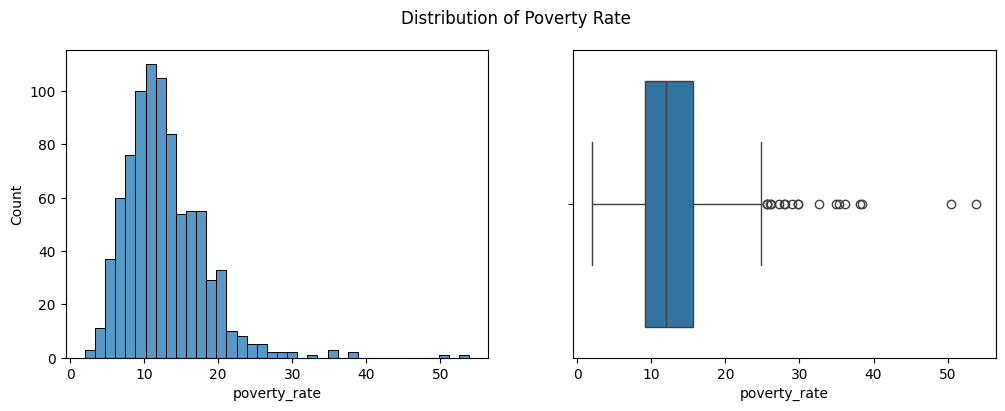

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row and 2 columns
# Create histogram
sns.histplot(df['poverty_rate'], ax=axes[0])
# Create boxplot
sns.boxplot(x=df['poverty_rate'], ax=axes[1])

fig.suptitle('Distribution of Poverty Rate')
plt.show()

In [8]:
# Check for rows containing outliers in poverty rate
Q1 = df['poverty_rate'].quantile(0.25)
Q3 = df['poverty_rate'].quantile(0.75)
IQR = Q3 - Q1
df[df['poverty_rate'] >= (Q3 + 1.5*IQR)]

,county,poverty_rate,health_insurance,median_household_income,unemployment_rate,public_transit,median_house_value,median_gross_rent,bachelor_holders,public_assistance
23,"Apache County, Arizona",29.8,86.0,40539,11.2,0.3,52700,607,8.53,2.97
28,"Navajo County, Arizona",25.6,87.1,50754,8.1,0.6,241400,869,10.78,3.45
155,"Bulloch County, Georgia",25.6,89.9,54007,7.0,1.3,240200,927,16.14,1.06
166,"Dougherty County, Georgia",26.1,88.2,45769,11.3,0.7,144500,856,7.67,1.31
386,"Lauderdale County, Mississippi",25.6,90.2,50542,7.6,0.0,145600,840,11.31,0.82
449,"McKinley County, New Mexico",38.2,81.1,40108,10.9,0.2,71000,768,6.37,1.61
456,"Bronx County, New York",27.9,93.3,46838,9.3,52.5,498200,1352,14.49,10.55
526,"Robeson County, North Carolina",28.1,87.1,40996,4.7,0.2,87100,786,8.84,0.36
720,"Hidalgo County, Texas",27.2,74.7,53661,5.6,0.2,151200,936,12.82,1.94
740,"Starr County, Texas",29.0,74.5,41566,7.0,0.0,89600,747,8.33,2.07


**Key findings:** Most of the outliers in poverty rate are from counties in Puerto Rico, which is a U.S. territory. It's socioeconomic and demographic characteristics are significantly different from those in U.S. states. Including Puerto Rico's data with U.S. states might distort the regression results because Puerto Rico's extreme values could skew the model.

**Solution:** 
- Remove Puerto Rico from the analysis.
- Other outliers in the response variable and in explanatory variables are likely to be legitimate extreme values. Since the data comes from a reputable source like the U.S. Census Bureau, it's likely to be cleaned and processed carefully already. The Census Bureau employs robust methods for estimating and adjusting the data, and any extreme values or outliers might reflect genuine socio-economic conditions in specific counties rather than errors.

In [9]:
# Remove counties in Puerto Rico
df = df[~df['county'].str.contains('Puerto Rico')]
df.shape

(843, 10)

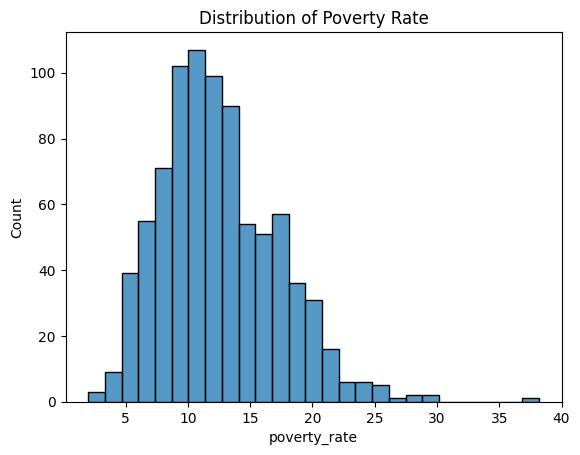

In [10]:
# Observe the distribution of poverty rate again
sns.histplot(df['poverty_rate'])
plt.title('Distribution of Poverty Rate')
plt.show()

### 3. Correlation Between Variables

In [11]:
# Create a dataframe with independent and dependent variables only
df_num = df.drop('county', axis=1)

#### 3.1 Multicolinearity

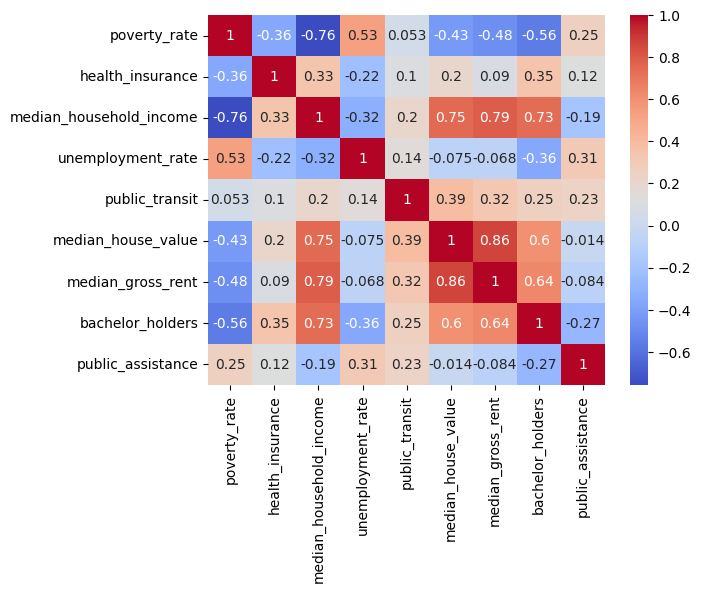

In [12]:
corr_matrix = df_num.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

**Key findings:**

1. A 0.86 correlation coeficient between ``median_gross_rent`` and ``median_house_value`` suggests that there is a strong positive correlation between these two variables.
2. ``public_transit`` has a very weak positive correlation (0.053) with poverty_rate, indicating little relationship between poverty rate and the percentage of people commuting to work by public transit.
3. The coefficient between ``public_assistance`` and ``poverty_rate`` is 0.25 which indicates a relatively weak positive relationship.

Sometimes, a variable with a weak correlation may still be statistically significant in the model due to its unique contribution when combined with other variables. Removing variables prematurely may lead to an underfitting model.

The below code to calculate VIFs was adapted from Vikash Singh on DataCamp: [LINK](https://www.datacamp.com/tutorial/variance-inflation-factor)

In [13]:
# Identify independent variables
predictors = df_num.drop(columns='poverty_rate')

# Add constant term for intercept
predictors = sm.add_constant(predictors)  

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['variable'] = predictors.columns
vif_data['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
print(vif_data)

                  variable         VIF
0                    const  794.168036
1         health_insurance    1.461573
2  median_household_income    4.460533
3        unemployment_rate    1.414113
4           public_transit    1.344033
5       median_house_value    4.575705
6        median_gross_rent    5.933254
7         bachelor_holders    2.708681
8        public_assistance    1.369089


**Key findings:**   
- VIF for ``median_gross_rent`` is a bit high (5.93). It suggests that ``median_gross_rent`` is highly correlated with one or more other variables (likely with ``median_house_value``, given the previous correlation of 0.86). 
- VIF for ``median_house_value`` is also relatively high (4.46), but it’s below the critical threshold of 5.

**Solution:** To avoid multicollinearity, I will remove ``median_gross_rent``.

In [14]:
df_num.drop(columns='median_gross_rent', inplace=True)
df_num.head(1)

,poverty_rate,health_insurance,median_household_income,unemployment_rate,public_transit,median_house_value,bachelor_holders,public_assistance
0,9.7,93.2,72915,2.0,0.0,307000,20.64,0.58


#### 3.2 Linearity

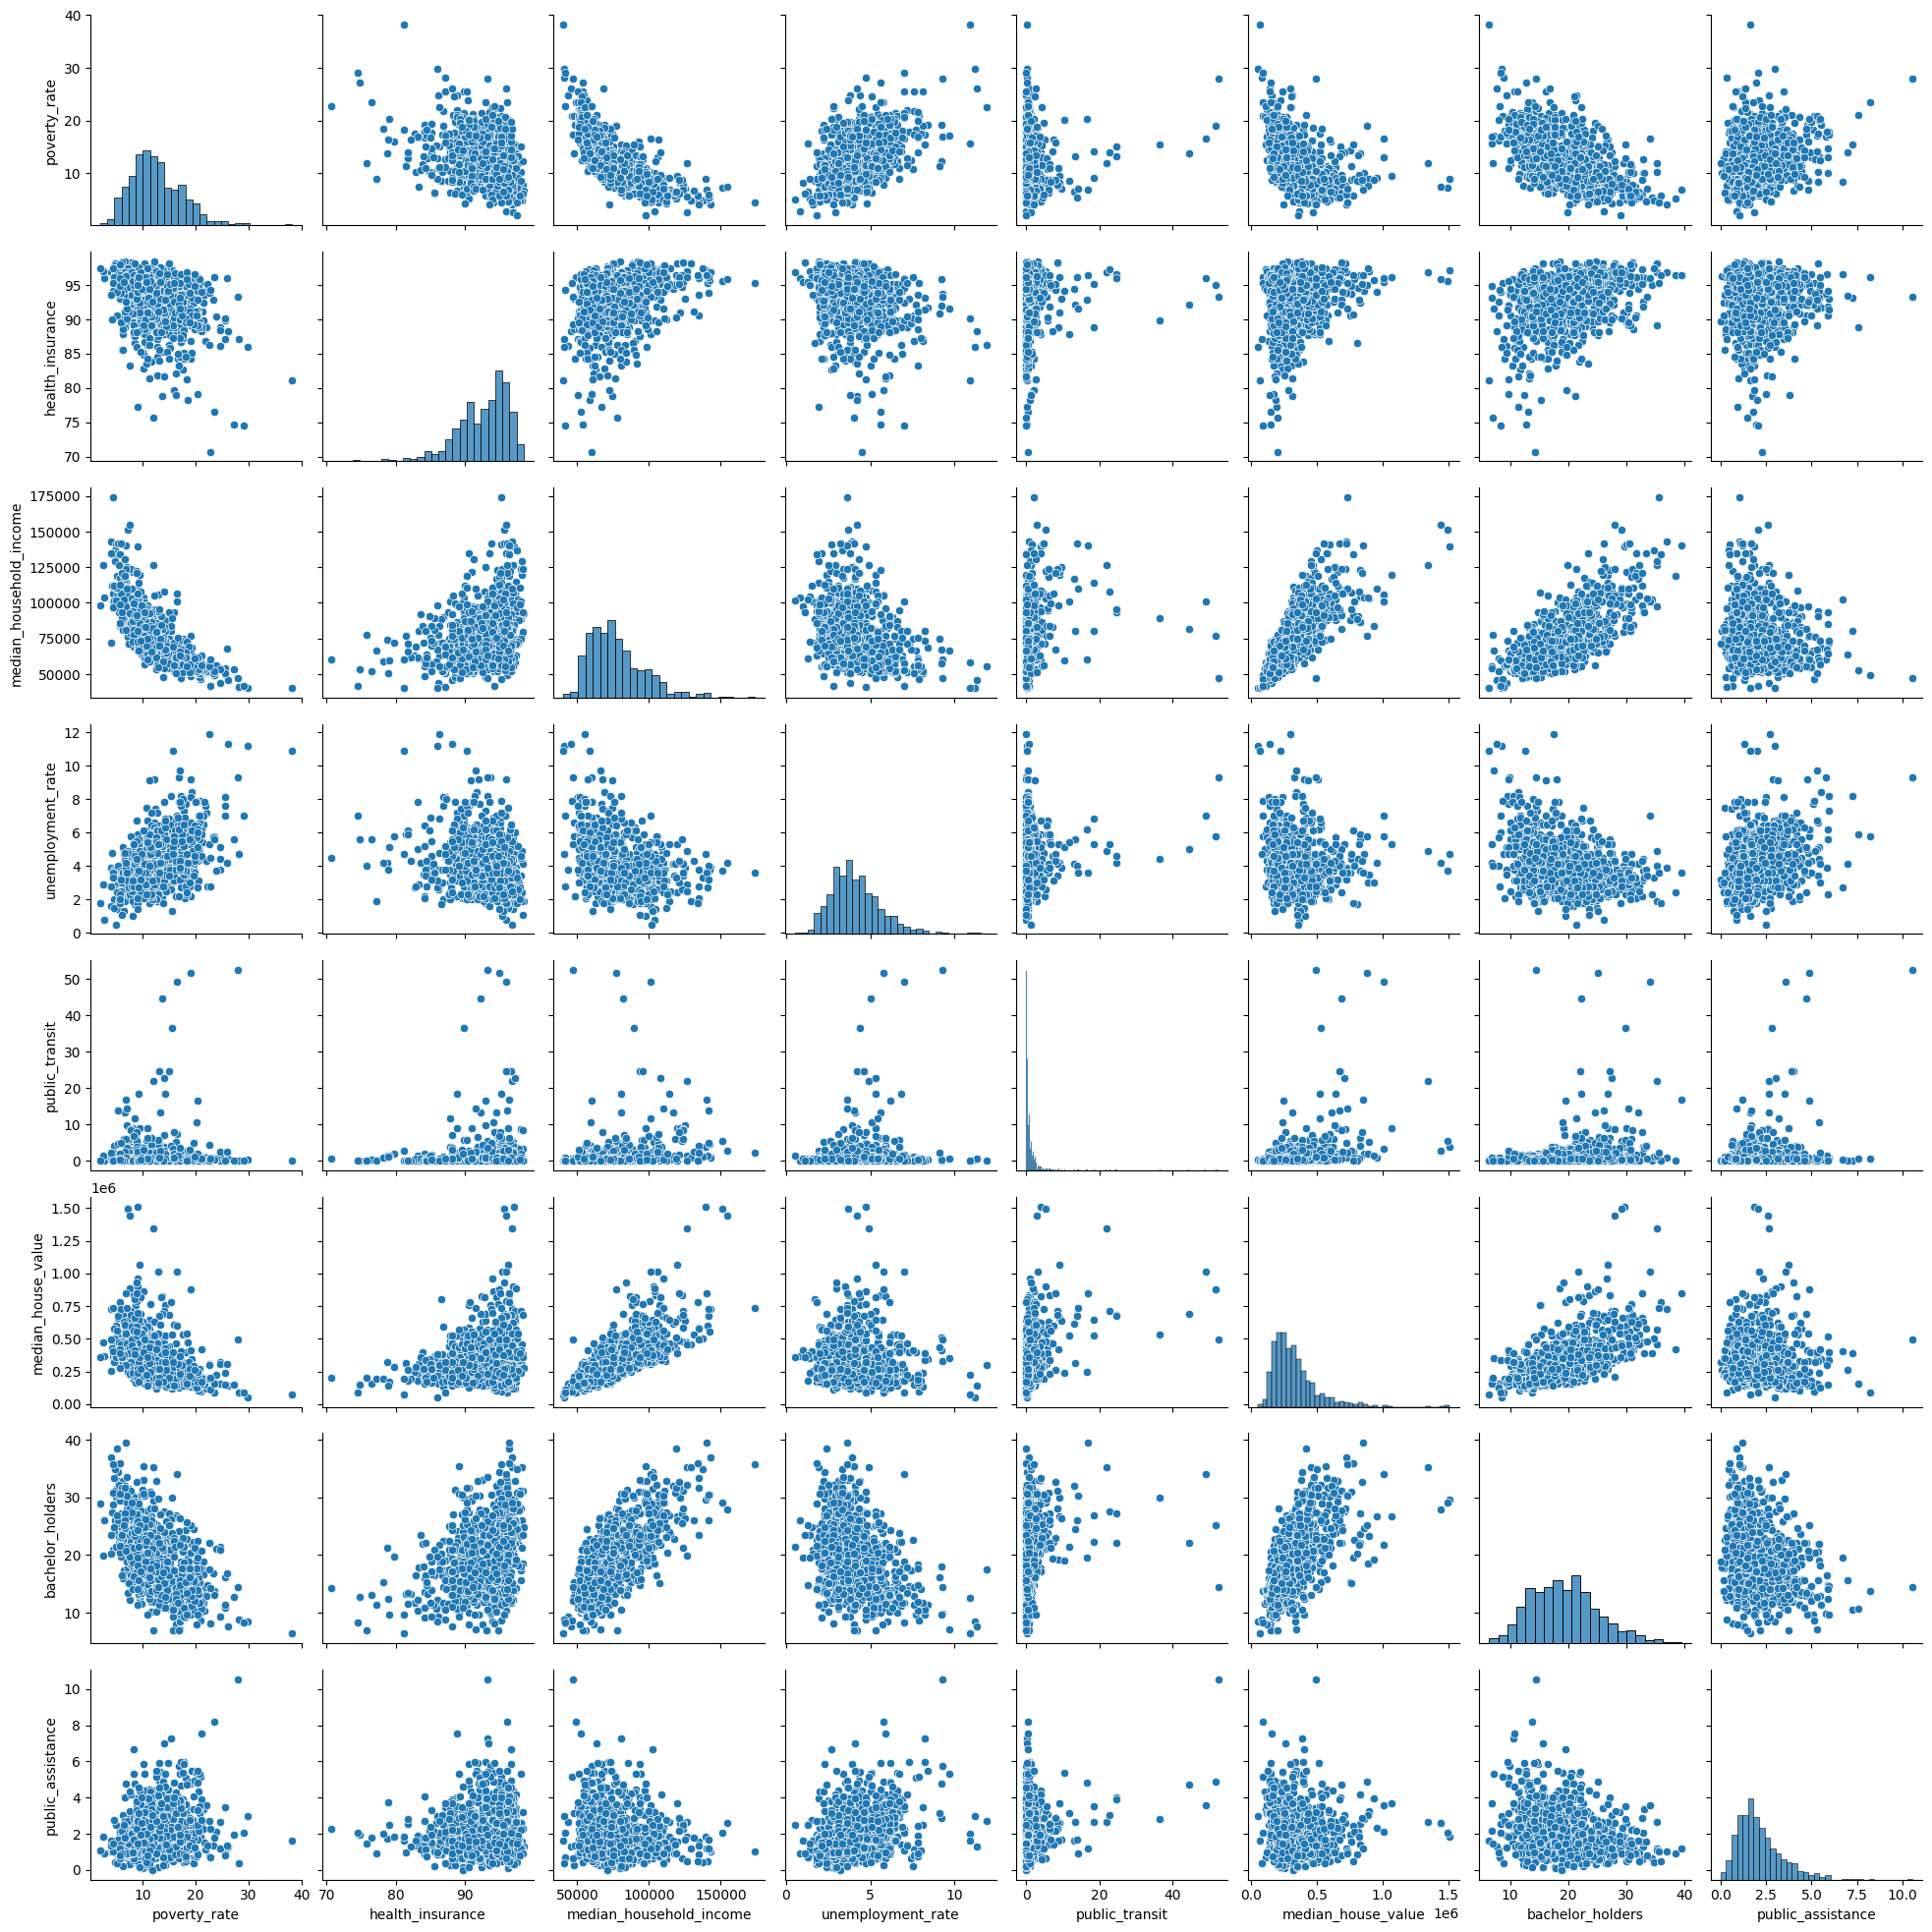

In [15]:
# Visualizing the relationships between features using pairplot
sns.pairplot(df_num)

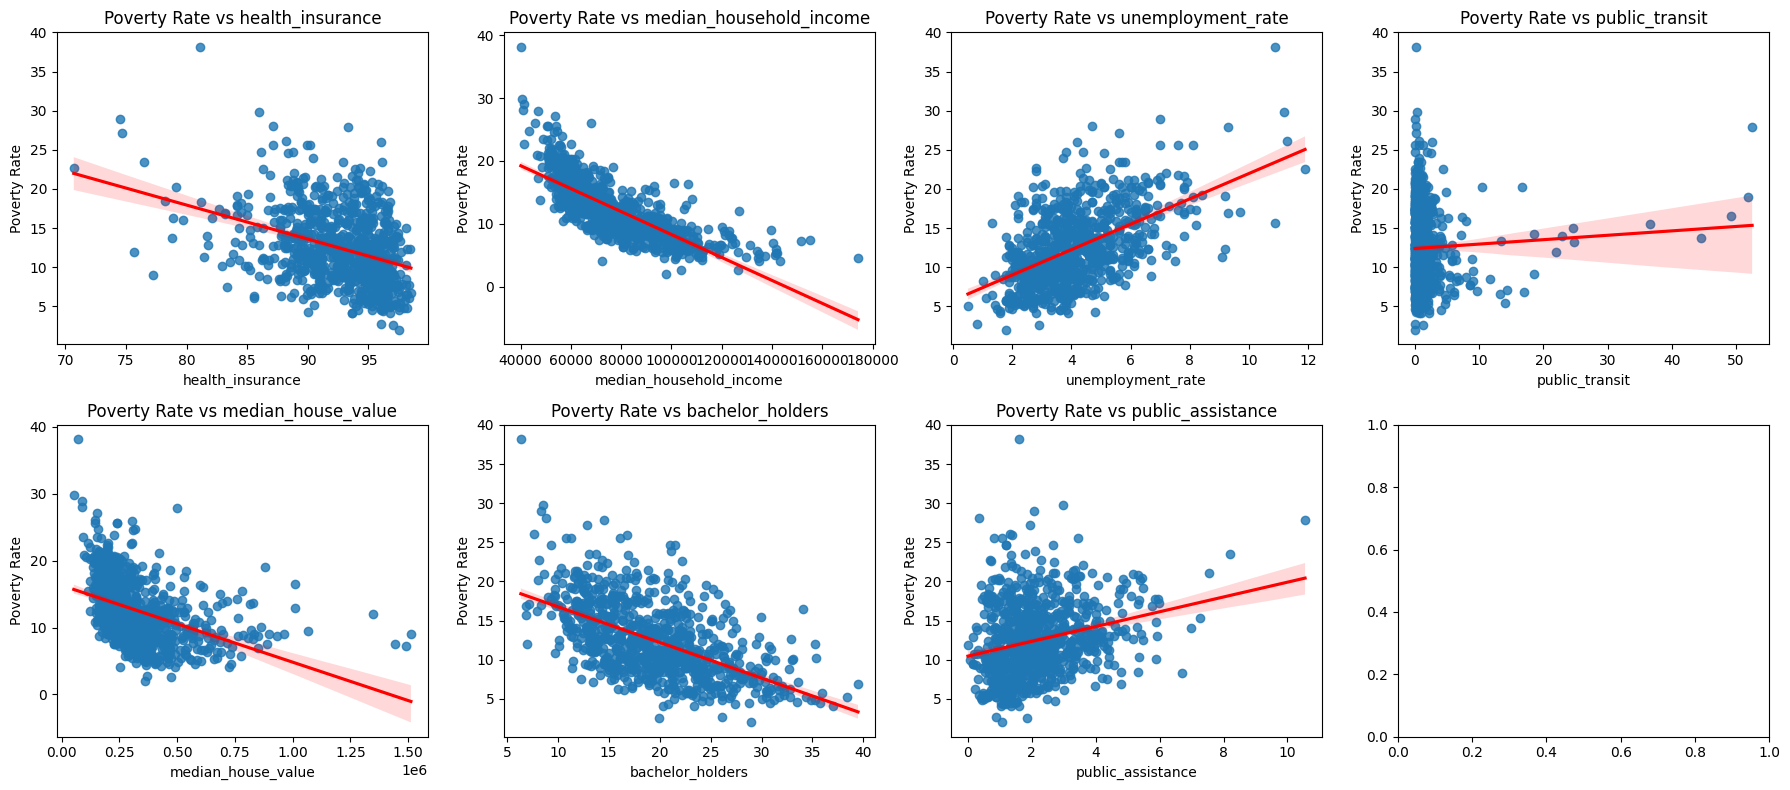

In [16]:
# List of the predictor columns
predictors = df_num.drop(columns =['poverty_rate'])

# Create a figure with a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each predictor and plot the scatter plot with regression line
for i, predictor in enumerate(predictors):
    sns.regplot(x=df[predictor], y=df['poverty_rate'], ax=axes[i], line_kws={'color': 'red'})
    axes[i].set_xlabel(predictor)
    axes[i].set_ylabel('Poverty Rate')
    axes[i].set_title(f'Poverty Rate vs {predictor}')
plt.tight_layout()
plt.show()

**Key findings:**
- ``median_household_income``: The regression looks curved, meaning it's non-linear.
- ``public_transit``: Data is heavily concentrated near zero, but the regression line may not fit well overall (possible non-linearity).
- ``median_house_value``: There's a slight curve which indicates non-linearity.

***Inspecting ``median_household_income``:***

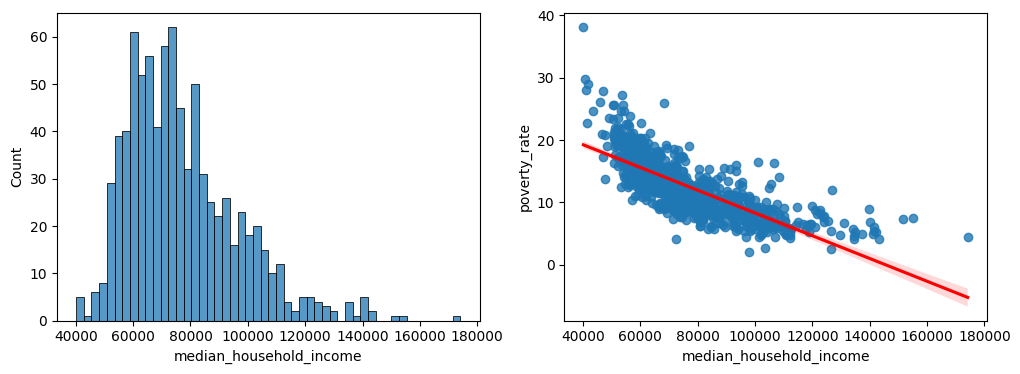

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
sns.histplot(df_num['median_household_income'], bins=50, ax=axes[0])
# Scatter plot
sns.regplot(x='median_household_income', y='poverty_rate', data=df_num, line_kws={"color": "red"}, ax=axes[1])
plt.show()

**Key findings:** The distribution of ``median_household_income`` is right-skewed, and the correlation with response variable is strong but non-linear.

**Solution:** Log transformation can help reduce skewness and fit the data in a more linear relationship.

In [18]:
# Apply log transformation
df_num['log_median_income'] = np.log(df_num['median_household_income'])
df_num.drop(columns='median_household_income', inplace=True)

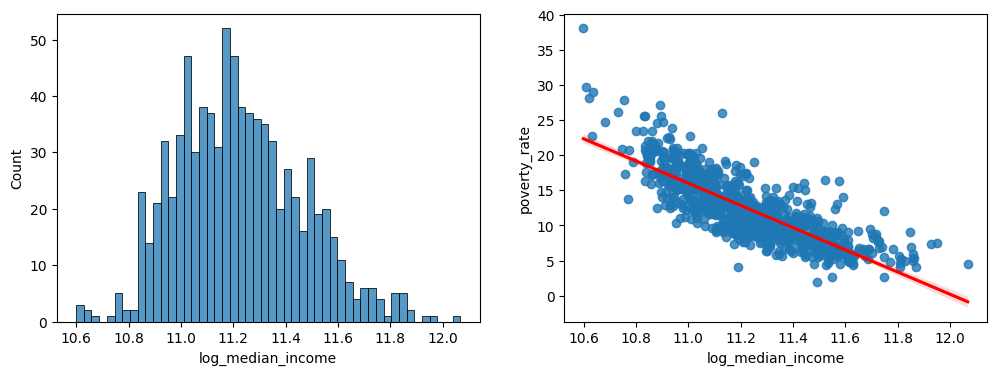

In [19]:
# Check the plots again after log transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
sns.histplot(df_num['log_median_income'], bins=50, ax=axes[0])

# Scatter plot
sns.regplot(x='log_median_income', y='poverty_rate', data=df_num, line_kws={'color': 'red'}, ax=axes[1])
plt.show()

***Inspecting ``public_transit``:***

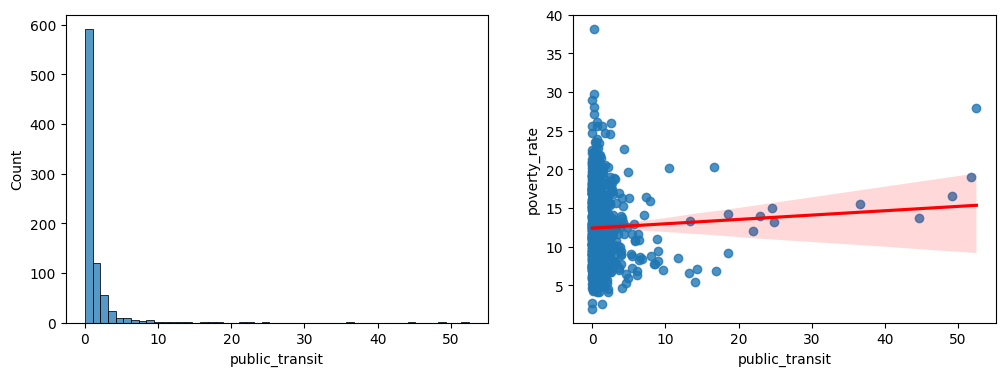

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
sns.histplot(df_num['public_transit'], bins=50, ax=axes[0])

# Scatter plot
sns.regplot(x='public_transit', y='poverty_rate', data=df_num, line_kws={'color': 'red'}, ax=axes[1])
plt.show()

**Key findings:** The distribution of ``public_transit`` is highly skewed, and the correlation with response variable is very weak.

**Solution:** Log transformation can help in modeling. I will add 1 to avoid issues with zero values (log(public_transit + 1)).

In [21]:
# Apply log transformation
df_num['log_public_transit'] = np.log1p(df_num['public_transit'])
df_num.drop(columns='public_transit', inplace=True)

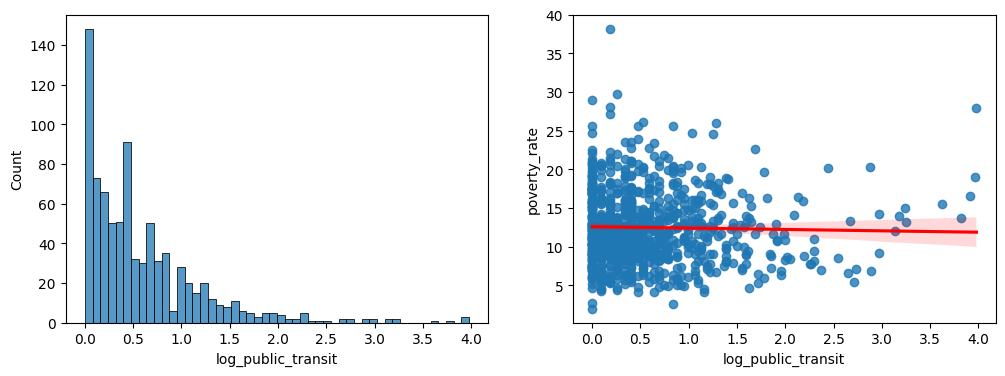

In [22]:
# Check the plots again after log transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
sns.histplot(df_num['log_public_transit'], bins=50, ax=axes[0])

# Scatter plot
sns.regplot(x='log_public_transit', y='poverty_rate', data=df_num, line_kws={'color': 'red'}, ax=axes[1])
plt.show()

***Inspecting ``median_house_value``:***

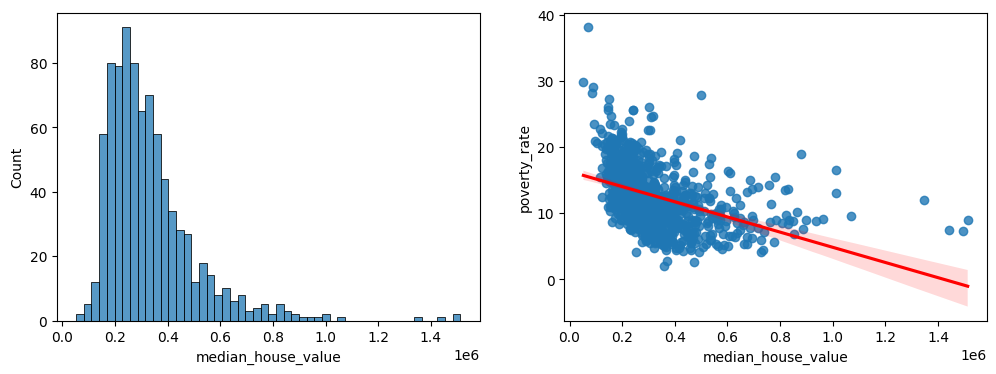

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
sns.histplot(df_num['median_house_value'], bins=50, ax=axes[0])

# Scatter plot
sns.regplot(x='median_house_value', y='poverty_rate', data=df_num, line_kws={'color': 'red'}, ax=axes[1])
plt.show()

**Key findings:** The distribution of ``median_household_value`` is positively skewed, and the correlation with response variable is slightly curved.

**Solution:** Square root transformation can help make the relationship more linear, but the data will not be as distorted as it would with log transformation.

In [24]:
# Apply square root transformation
df_num['sqrt_median_house_value'] = np.sqrt(df_num['median_house_value'])
df_num.drop(columns='median_house_value', inplace=True)

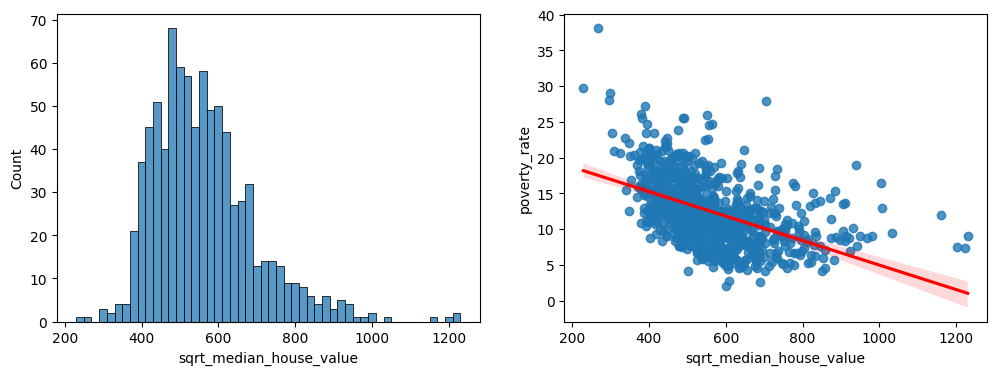

In [25]:
# Check the plots again after log transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
sns.histplot(df_num['sqrt_median_house_value'], bins=50, ax=axes[0])

# Scatter plot
sns.regplot(x='sqrt_median_house_value', y='poverty_rate', data=df_num, line_kws={'color': 'red'}, ax=axes[1])
plt.show()

In [26]:
# Save dataset with transformed predictors
df_num.to_csv('transformed_data.csv', index=False)
# Check the saved CSV file
df = pd.read_csv('transformed_data.csv')
df.head()

,poverty_rate,health_insurance,unemployment_rate,bachelor_holders,public_assistance,log_median_income,log_public_transit,sqrt_median_house_value
0,9.7,93.2,2.0,20.64,0.58,11.197050,0.000000,554.075807
1,21.3,91.1,5.4,11.84,1.65,10.835258,0.000000,401.123422
2,18.3,89.4,3.8,10.75,1.34,10.983987,0.262364,451.663592
3,24.7,86.1,3.8,9.33,2.66,10.680723,0.000000,395.979797
4,12.9,92.4,2.7,17.73,0.17,11.191038,0.000000,479.478884


## B. Feature Scaling

MinMaxScaler is applied to ensure that the predictors are on the same scale and coefficients in the regression model are standardized.

In [27]:
predictors = df_num.drop(columns='poverty_rate')
# Apply scaling
scaler = MinMaxScaler()
scaled_predictors = scaler.fit_transform(predictors)
scaled_predictors = pd.DataFrame(scaled_predictors, columns=predictors.columns)
scaled_predictors.head()

,health_insurance,unemployment_rate,bachelor_holders,public_assistance,log_median_income,log_public_transit,sqrt_median_house_value
0,0.809353,0.131579,0.431118,0.054976,0.407074,0.000000,0.324462
1,0.733813,0.429825,0.165257,0.156398,0.160677,0.000000,0.171533
2,0.672662,0.289474,0.132326,0.127014,0.261968,0.065926,0.222065
3,0.553957,0.289474,0.089426,0.252133,0.055432,0.000000,0.166390
4,0.780576,0.192982,0.343202,0.016114,0.402980,0.000000,0.249876


## C. Building Regression Model (Baseline Model)

An OLS model is fitted on transformed and scaled predictors with train/test split.

In [28]:
# Add intercept to scaled predictors and specify the dependent variable
X = sm.add_constant(scaled_predictors)
y = df_num['poverty_rate']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
ols = sm.OLS(y_train, X_train)
model = ols.fit()

## D. Model Evaluation

In [29]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

R-squared: 0.7960750041154723
Mean Squared Error: 4.355126198792516


**Key findings:**
- The model explains 79.61% of the variance in poverty rates on unseen data.
- On average, the squared difference between predicted and actual poverty rates is 4.36.

In [30]:
# View model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           poverty_rate   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     307.1
Date:                Tue, 22 Apr 2025   Prob (F-statistic):          1.04e-203
Time:                        23:14:51   Log-Likelihood:                -1513.3
No. Observations:                 674   AIC:                             3043.
Df Residuals:                     666   BIC:                             3079.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

**Key findings:**
- Training set R-squared: The model explains 76.3% of the variance in poverty rates.
- Prob (F-statistic): very small p-value for hypothesis test. We can reject the null hypothesis, which means at least one predictor has a significant effect on poverty rate.
- Insignificant predictors: ``bachelor_holders`` (p-value: 0.129), ``log_public_assistance`` (p-value: 0.899)
- ``log_median_income`` has the largest absolute value of standardized coefficient, which means this predictor is the most influential predictor in this model. 
- One unexpected finding is that ``sqrt_median_house_value`` has a positive coefficient, which means higher house values associate with higher poverty rates. However, the scatter plot ``poverty_rate`` vs. ``sqrt_median_house_value`` suggests otherwise.

***It is important to note that this baseline model may suffer from assumption violations (e.g., heteroscedasticity, skewness), so coefficient estimates and p-values may be less reliable. I will need to conduct model diagnostics and possibly model refinement before concluding a final answer to the research question.***

## E. Model Diagnostics (Residual Analysis)

### 1. Constant Variance (Homoscedasticity)

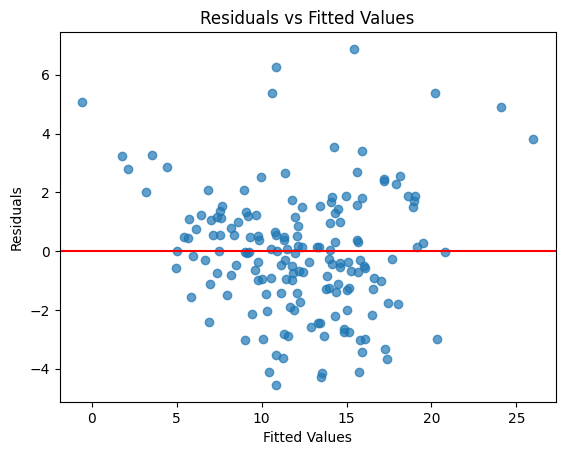

In [31]:
# Residuals vs fitted values plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

**Key findings:**
- Residuals are scattered faily symmetrically around 0: Model doesn't have major bias
- Mild funnel or cone shape (the residuals seem to spread out more as fitted values increase): Possible heteroscedasticity
- A few large residuals: these could be outliers.

### 2. Linearity

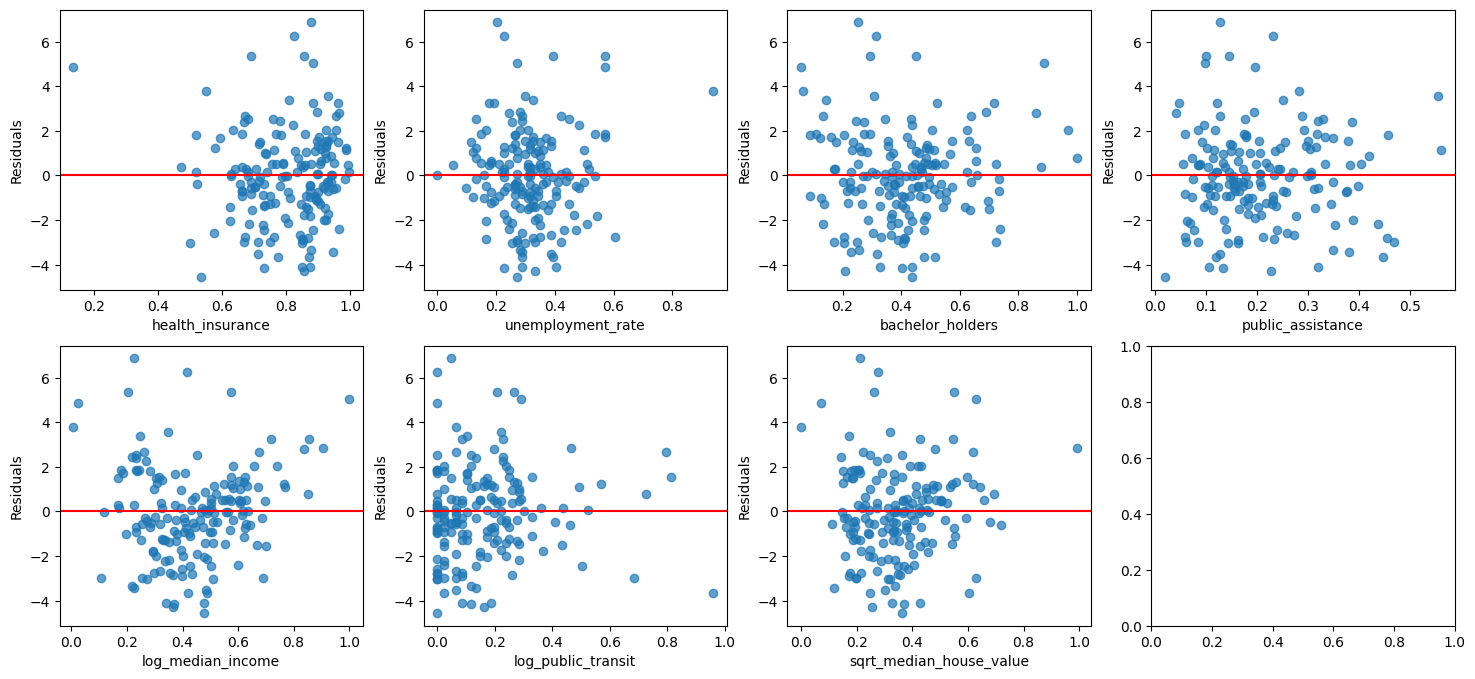

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(18,8))
axes = axes.flatten()
predictors = X_test.drop(columns = 'const')
for i, col in enumerate(predictors.columns):
    axes[i].scatter(predictors[col], residuals, alpha=0.7)
    axes[i].axhline(0, color='r')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Residuals')
plt.show()

**Key findings:**
- For most plots, the points are fairly symmetrically scattered around 0, except for ``log_median_income``.
- ``log_median_income``: Slight curved (U-shape) pattern suggests a nonlinear relationship.
- ``bachelor_holders``: This residual plot suggests that linearity is not the issue. The lack of significance (high p-value) is more likely due to low correlation with the outcome after adjusting for other variables.

### 3. Normality

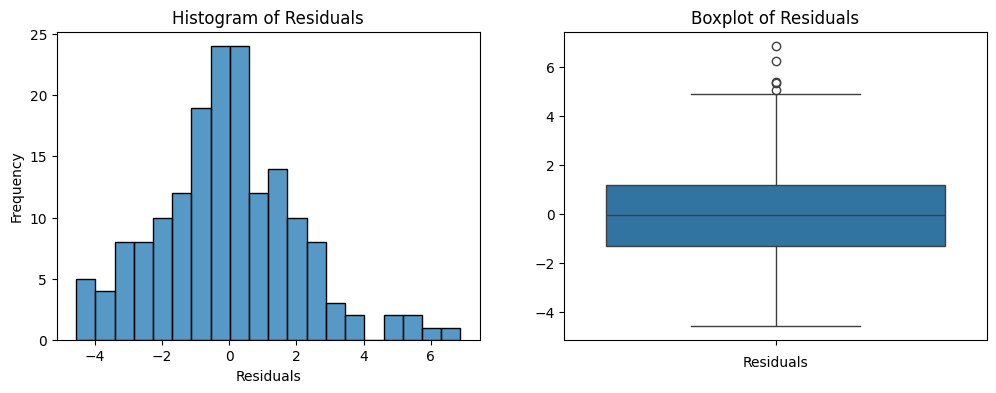

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
# Histogram of residuals
sns.histplot(residuals, bins=20, edgecolor='black', ax=axes[0])
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Boxplot of residuals
sns.boxplot(residuals, ax=axes[1])
axes[1].set_title('Boxplot of Residuals')   
axes[1].set_xlabel('Residuals')

plt.show()

**Key findings:**
- The residuals are centered around 0
- The distribution of residuals is slightly skewed left.
- Boxplot shows a few outliers at higher end.

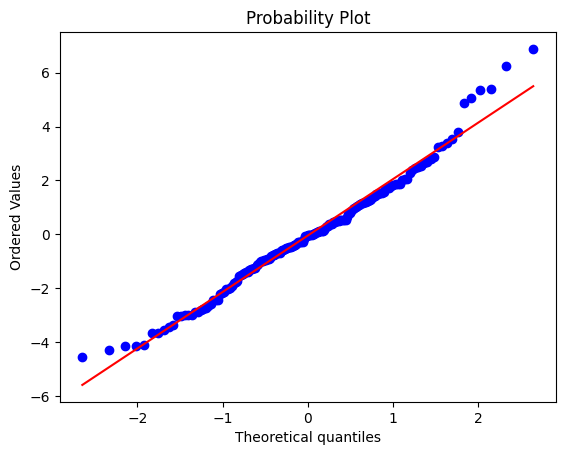

In [34]:
# Q-Q plot to check for normality of residuals
stats.probplot(residuals, dist='norm', plot=plt)
plt.show()

**Key findings:**
- The residuals in the center are fairly normal.
- The deviation from the line in the tails confirms what we saw in the histogram and boxplot: There're outliers on the right (larger positive residuals).

## F. Model Refinement
I refined the model step by step to see how each change affected performance and to make sure I only included adjustments that clearly improved model performance or fixed specific issues.  
Experiments with various model refinement methods were conducted in a separate notebook to keep this main analysis clean and focused.
Please refer to [model_refinement_experiments.ipynb](./model_refinement_experiments.ipynb) for detailed exploratory model testing and rationale behind the final model choices presented here.

### 1. Transforming Dependent Variable

Applying a square root transformation to the response variable helps stabilize variance and reduce skewness.

In [35]:
# Apply transformation
df_num['sqrt_poverty_rate'] = np.sqrt(df_num['poverty_rate'])

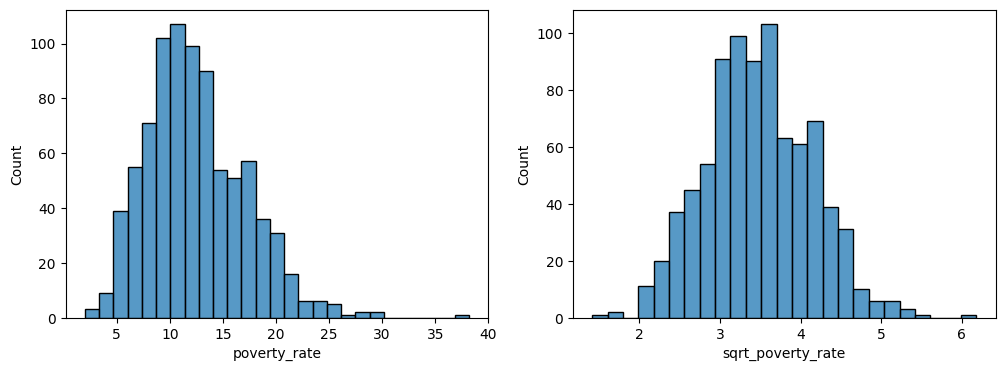

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
# Compare the distribution of poverty rate before and after transformation
sns.histplot(df_num['poverty_rate'], ax=axes[0])
sns.histplot(df_num['sqrt_poverty_rate'], ax=axes[1])

plt.show()

**Key findings:** The response variable is more symetrically distributed after applying square root transformation.

### 2. Interaction Term

Adding interaction terms allows the model to capture more complex, real-world relationships between predictors. 

An interaction term can be identified by asking: Do any predictors influence each other’s effects on the dependent variable? Socioeconomic variables may not act independently in influencing poverty. In the baseline model, I'm assuming that household income has the same effect everywhere, regardless of house values. But what if counties with medium to high income have housing affordability issues? The impact of household income on poverty may differ based on local housing cost.

The below code for generating a scatter plot with customized hue levels is adapted from JohanC on Stack Overflow: [LINK](https://stackoverflow.com/a/70342221)

In [37]:
# Bin sqrt_median_house_value into categories
bins = [0, 600, 1300]
labels = ['Low', 'High']
house_value_bin = pd.cut(df_num['sqrt_median_house_value'], bins=bins, labels=labels)

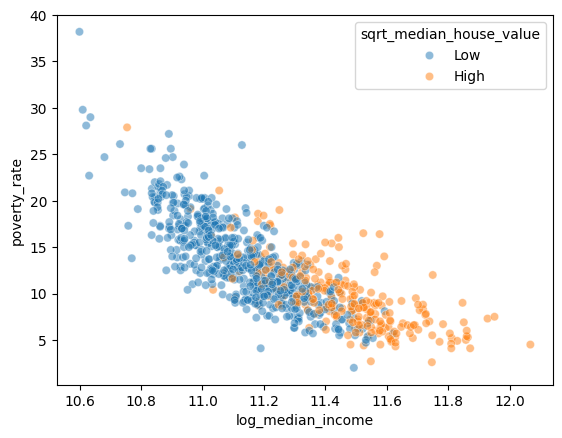

In [38]:
sns.scatterplot(x='log_median_income', y='poverty_rate', hue=house_value_bin, data=df_num, alpha=0.5)
plt.show()

**Key findings:**
- There's a clear negative relationship between ``log_median_income`` and ``poverty_rate``.
- Higher housing cost also associates with higher income
- At the same income level, counties with higher ``sqrt_median_house_value`` (orange points) seem to have higher poverty rates than counties with lower house values (blue points).
- For counties with lower house value, the drop in poverty rate with increasing income appears steeper than ones with higher house value. This means that the effect of income on poverty varies depending on house values.

In [39]:
df_num['income_x_house_value'] = (df_num['log_median_income'] * df_num['sqrt_median_house_value'])

### 3. Fitting a New Model with Robust Standard Errors

Using robust standard errors (HC3) corrects for heteroscedasticity and ensures valid inference, especially for the t-tests and confidence intervals on coefficients.

#### 3.1 Scaling:

In [40]:
predictors = df_num.drop(columns=['sqrt_poverty_rate', 'poverty_rate'])
# Apply scaling
scaler = MinMaxScaler()
scaled_predictors = scaler.fit_transform(predictors)
scaled_predictors = pd.DataFrame(scaled_predictors, columns=predictors.columns)
scaled_predictors.head()

,health_insurance,unemployment_rate,bachelor_holders,public_assistance,log_median_income,log_public_transit,sqrt_median_house_value,income_x_house_value
0,0.809353,0.131579,0.431118,0.054976,0.407074,0.000000,0.324462,0.310475
1,0.733813,0.429825,0.165257,0.156398,0.160677,0.000000,0.171533,0.157415
2,0.672662,0.289474,0.132326,0.127014,0.261968,0.065926,0.222065,0.208068
3,0.553957,0.289474,0.089426,0.252133,0.055432,0.000000,0.166390,0.147781
4,0.780576,0.192982,0.343202,0.016114,0.402980,0.000000,0.249876,0.241420


#### 3.2 New model:

In [41]:
# Add intercept to scaled explanatory data and specify the dependent variable
X = sm.add_constant(scaled_predictors)
y = df_num['sqrt_poverty_rate']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model with HC3 robust standard errors
ols = sm.OLS(y_train, X_train)
refined_model = ols.fit(cov_type='HC3')

### 4. New model evaluation

In [42]:
# Make predictions on the test set
y_pred = refined_model.predict(X_test)

# Calculate R-squared and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

R-squared: 0.8310581036269753
Mean Squared Error: 0.07192225315999502


**Key findings:**
- The model explains 83.11% of the variance in poverty rates on unseen data, higher than the baseline model's R-squared on test set. 
- MSE is 0.072, which is much lower than the baseline model (4.32).

In [43]:
# View model summary
print(refined_model.summary())

                            OLS Regression Results                            
Dep. Variable:      sqrt_poverty_rate   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     312.2
Date:                Tue, 22 Apr 2025   Prob (F-statistic):          2.10e-219
Time:                        23:14:53   Log-Likelihood:                -139.94
No. Observations:                 674   AIC:                             297.9
Df Residuals:                     665   BIC:                             338.5
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

**Key findings:**
- The refined model explains more variance (79.6%) in the transformed dependent variable. Even after penalizing for complexity, the new model still better fits the data.
- Prob (F-statistic): p-value is extremely small, so we can reject the null hypothesis.
- ``bachelor_holders`` and ``public_assistance`` (with high p-values) are still the 2 insignificant predictors in the model.
- ``sqrt_median_house_value``, ``log_median_income``, ``unemployment_rate``, ``log_public_transit`` and ``health_insurance`` remain high-impact predictors.
- ``sqrt_median_house_value`` is the most impactful individual predictor as its coefficient is the largest in absolute value among individual predictors (not including the interaction term).
- ``income_x_house_value`` is significant (p-value = 0). This suggests the effect of income on poverty varies by home value, and vice versa.
- A positive coefficient for the interaction term suggests that as income increases, the negative effect of house value on poverty becomes less strong, or as house value increases, the negative effect of income on poverty rate weakens.
- The sign of ``sqrt_median_house_value``'s coefficient flips due to the interaction term in the refined model. The negative coefficient means that higher housing values are associated with lower poverty rates. This effect of house values aligns more with general economic assumptions.

Once I transformed the response variable and introduced interaction, I get a clearer, more interpretable model.

Let's visualize the relative importance of each predictor.  
The following code for generating a tornado diagram is adapted from Brydon: [LINK](https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/10_multiple_regression.html#tornado-diagram)

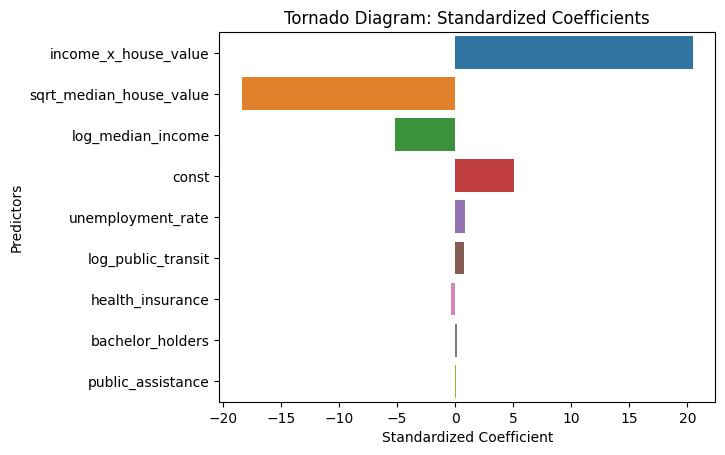

In [44]:
# Visualize standardized coefficients 
coeff = refined_model.params
coeff = coeff.iloc[(coeff.abs()*-1.0).argsort()]
sns.barplot(x=coeff.values, y=coeff.index, orient='h', hue=coeff.index)
plt.title('Tornado Diagram: Standardized Coefficients')
plt.xlabel('Standardized Coefficient')
plt.ylabel('Predictors')
plt.show()

**Key findings:**
- The interaction term (income × house value) dominates in explanatory power.
- ``sqrt_median_house_value`` and ``log_median_income`` are the 2 most impactful factors, and they both have negative effects on poverty rates.

### 5. Residual Analysis

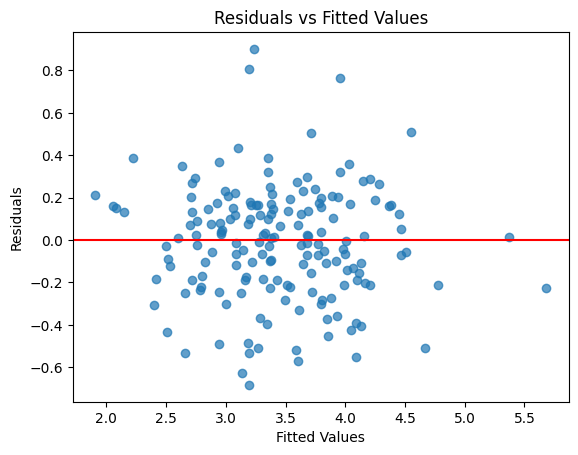

In [45]:
# Residuals vs fitted values plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

**Key findings:**
- The points are scattered fairly randomly around the red zero line.
- Residual spread appears relatively consistent across fitted values (no funnel shape). This indicates homoscedasticity.
- There seem to be a few outliers.

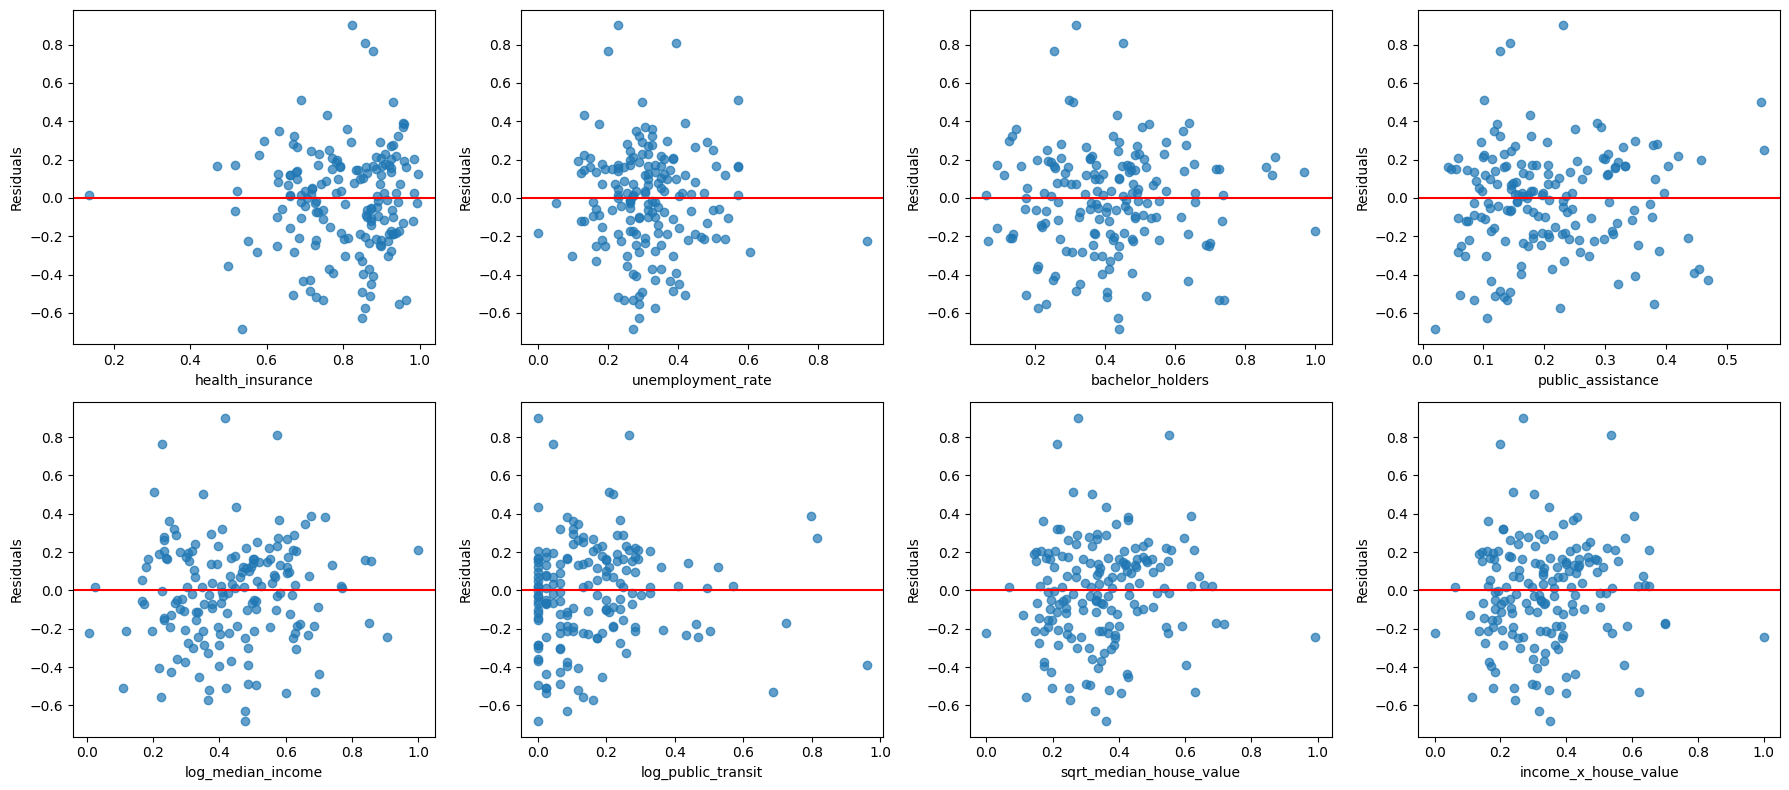

In [46]:
fig, axes = plt.subplots(2, 4, figsize=(18,8))
axes = axes.flatten()
predictors = X_test.drop(columns = 'const')
for i, col in enumerate(predictors.columns):
    axes[i].scatter(predictors[col], residuals, alpha=0.7)
    axes[i].axhline(0, color='r')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

**Key findings:** There're no major pattern and no obvious heteroscedasticity across all plots.

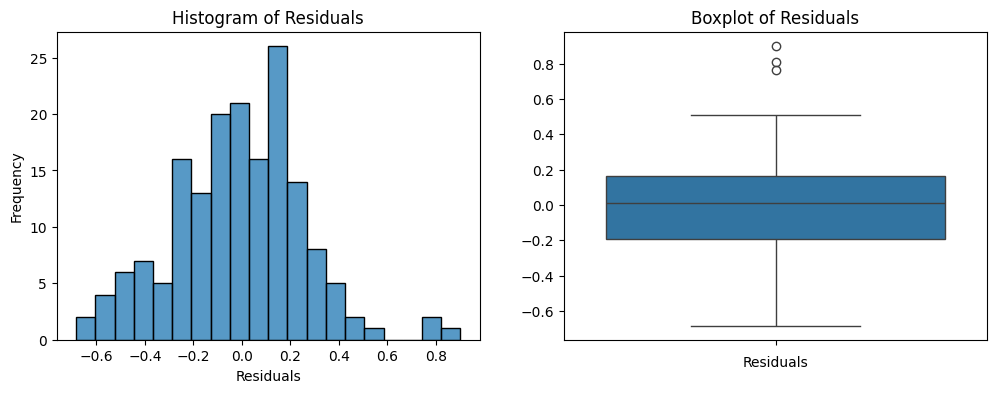

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
# Histogram of residuals
sns.histplot(residuals, bins=20, edgecolor='black', ax=axes[0])
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Boxplot of residuals
sns.boxplot(residuals, ax=axes[1])
axes[1].set_title('Boxplot of Residuals')   
axes[1].set_xlabel('Residuals')

plt.show()

**Key findings:** Normality of residuals is reasonably satisfied.
- The distribution is roughly bell-shaped and fairly symmetrical.
- Median is very close to zero. There're only a few mild outliers at the upper tail.

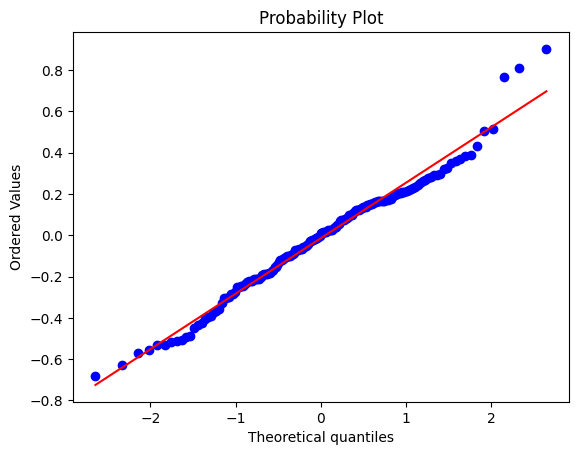

In [48]:
# Q-Q plot to check for normality of residuals
stats.probplot(residuals, dist='norm', plot=plt)
plt.show()

**Key findings:** The residuals still appear to be approximately normally distributed.
- Most of the blue points lie very close to the red reference line.
- A slight deviation is observed at the upper-right tail, which is acceptable.

## G. Conclusion

- The refined multiple linear regression model, which includes a transformed dependent variable, transformed and scaled predictors, and an interaction term, explains approximately 79.6% of the variation in county-level poverty rates.
- The refined model not only fits the training data well but also performs strongly on the test set with test R-squared of 0.831 and MSE of 0.072.
- The final model better fits the data, accounts for heteroscedasticity and addresses potential violations of OLS assumptions. This gives me more valid p-values and standard coefficients.
- The model's F-statistic is highly significant (p < 0.05). We can reject the global null hypothesis that all slope coefficients are zero. This confirms that at least some of the socioeconomic factors have a statistically significant impact on poverty rates.
- The most impactful predictors of poverty rates are ``median_house_value`` and ``median_income`` as they both show strong negative relationships. Counties with higher home values and incomes tend to have lower poverty rates.
- Other significant factors (with p < 0.05) include:
    - Higher unemployment associates with higher poverty
    - Greater health insurance coverage comes with lower poverty
    - More public transit use relates to higher poverty (possibly reflecting urban conditions)
- Education level (bachelor_holders) and public assistance were not statistically significant in the refined model, which mean these factors have limited unique contribution when controlling for other factors.  
Note: The OPM does not include non-cash public assistance (like SNAP, housing subsidies, TANF) in its calculation. So counties with high assistance rates may not show reduced poverty under OPM even though aid might be helping in reality.